<a href="https://colab.research.google.com/github/kapilsh/gpt-oss-scratch/blob/main/gpt_oss_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math
from loguru import logger
from rope_visualization import *

# GPT OSS Architecture

![GPT OSS Architecture](./resources/gpt_oss_20b_architecture.jpg)

Let's build out these components one by one. In some cases, we can just see how the individual modules will work but there are already PyTorch version available so we will use that at the end

## RMS Norm

https://arxiv.org/pdf/1910.07467

![RMS Norm](./resources/rms_norm.png)

PyTorch already has an implementation of RMSNorm in `torch.nn.RMSNorm` but we can check our sample implementation wrt PyTorch one.

In [2]:
class RMSNorm(nn.Module):
    def __init__(self, embedding_dimension: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.embedding_dimension = embedding_dimension
        self.weight = nn.Parameter(torch.ones(embedding_dimension))

    def forward(self, x: torch.Tensor):
        means = x.pow(2).mean(dim=-1, keepdim=True)
        return (x * torch.rsqrt(means + self.eps)) * self.weight

In [3]:
x = torch.tensor(
    [
        [0.1200, -0.5600, 1.3400, 0.2200, -1.0500, 0.8700, -0.4400, 0.0900],
        [-0.9800, 0.4500, -0.1100, 0.6600, 0.7300, -0.3500, 0.2800, -0.6200],
        [0.5300, -0.7700, 0.0800, -0.3400, 0.1900, 1.0200, -0.5900, 0.4100],
        [1.2100, -0.1400, 0.3800, 0.7700, -0.9100, 0.6400, -0.2700, 0.1500],
    ]
)

rms_norm = RMSNorm(embedding_dimension=x.shape[-1])
rms_norm.weight.data = torch.tensor(
    [0.8, 1.2, 0.9, 1.1, 0.7, 1.3, 1.0, 0.95]
)  # Setting custom weights for demonstration
rms_norm_out = rms_norm(x)
logger.info(f"RMSNorm Output:\n{rms_norm_out}")

2025-09-14 21:46:20.140 | INFO     | __main__:<module>:15 - RMSNorm Output:
tensor([[ 0.1320, -0.9238,  1.6579,  0.3327, -1.0104,  1.5548, -0.6049,  0.1175],
        [-1.3424,  0.9246, -0.1695,  1.2431,  0.8749, -0.7790,  0.4794, -1.0085],
        [ 0.7454, -1.6244,  0.1266, -0.6575,  0.2338,  2.3311, -1.0372,  0.6847],
        [ 1.4523, -0.2520,  0.5131,  1.2707, -0.9557,  1.2482, -0.4051,  0.2138]],
       grad_fn=<MulBackward0>)



### Visualization

Here's is visualization of how RMSNorm works in practice taking a batch_size = 4 and embedding size = 8 example:

![RMS Norm Viz](./resources/rms_norm_viz.png)

### Test

In [4]:
torch.manual_seed(123)

example_batch = torch.randn(2, 3, 4)

rms_norm = RMSNorm(embedding_dimension=example_batch.shape[-1])
rmsnorm_pytorch = torch.nn.RMSNorm(example_batch.shape[-1], eps=1e-5)

assert torch.allclose(rms_norm(example_batch), rmsnorm_pytorch(example_batch))

## Rotary Embeddings (RoPE)

GPT OSS uses rotary position encoding for position embeddings. [RoPE Paper](https://arxiv.org/pdf/2104.09864). They also enhance the RoPE embedding using the [YaRN scaling](https://arxiv.org/pdf/2309.00071). 

![Rope gpt oss model card](./resources/gpt_oss_rope.png)

Rotary Position Embedding (RoPE) encodes positional information in transformer models by rotating query and key vectors in the attention mechanism based on their position in the sequence. The angles in rotations are modified based on YaRN scaling factors.

When computing attention between positions m and n, the rotation becomes a function of their difference (m-n), making the model naturally aware of relative distances rather than absolute positions. This makes RoPE highly effective for sequential understanding tasks. 

Example usage code ([source](https://github.com/openai/gpt-oss/blob/main/gpt_oss/torch/model.py#L240-L243)):

```python
k = k.view(-1, self.num_key_value_heads, self.head_dim)
v = v.view(-1, self.num_key_value_heads, self.head_dim)
q, k = self.rope(q, k)
t = sdpa(q, k, v, self.sinks, self.sm_scale, self.sliding_window)
```

The RoPE and YaRN papers have a lot of formulas but here is a simplified version visualized below:

![ROPE Embedding viz](./resources/gpt_oss_rope_embeddings_viz.png)

### Implementation

In [5]:
class RotaryEmbedding(torch.nn.Module):
    """Rotary Position Embedding with YaRN scaling support.

    Implements RoPE with optional YaRN-style scaling for context window extension.
    Supports both standard RoPE and YaRN enhancements including:
    - Non-uniform scaling across frequency dimensions
    - NTK-aware interpolation and extrapolation
    - Temperature-based concentration adjustment
    """

    def __init__(
        self,
        head_dim: int,
        base: int = 10000,
        dtype: torch.dtype = torch.float32,
        initial_context_length: int = 4096,
        scaling_factor: float = 1.0,
        ntk_alpha: float = 1.0,
        ntk_beta: float = 32.0,
        device: Optional[torch.device] = None,
    ) -> None:
        """Initialize RotaryEmbedding.

        Args:
            head_dim: Dimension of each attention head
            base: Base for frequency calculation (default: 10000)
            dtype: Data type for computations
            initial_context_length: Original training context length
            scaling_factor: YaRN scaling factor (>1.0 enables YaRN)
            ntk_alpha: NTK alpha parameter for high-freq scaling
            ntk_beta: NTK beta parameter for low-freq scaling
            device: Device for tensor operations
        """
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        self.dtype = dtype
        self.initial_context_length = initial_context_length
        self.scaling_factor = scaling_factor
        self.ntk_alpha = ntk_alpha
        self.ntk_beta = ntk_beta
        self.device = device

    @staticmethod
    def _apply_rotary_embedding(
        x: torch.Tensor,
        cos: torch.Tensor,
        sin: torch.Tensor,
    ) -> torch.Tensor:
        """Apply rotary position embedding to input tensor.

        Args:
            x: Input tensor of shape [..., seq_len, head_dim]
            cos: Cosine values of shape [seq_len, head_dim//2]
            sin: Sine values of shape [seq_len, head_dim//2]

        Returns:
            Rotated tensor with same shape as input
        """
        # Ensure cos/sin match input dtype and add dimension for broadcasting
        cos = cos.unsqueeze(-2).to(x.dtype)
        sin = sin.unsqueeze(-2).to(x.dtype)

        # Split into even/odd dimensions and apply rotation
        x_even, x_odd = x.chunk(2, dim=-1)
        rotated_even = x_even * cos - x_odd * sin
        rotated_odd = x_odd * cos + x_even * sin

        return torch.cat([rotated_even, rotated_odd], dim=-1)

    def _compute_frequency_and_concentration(self) -> Tuple[float, torch.Tensor]:
        """Compute YaRN concentration factor and inverse frequencies.

        Based on YaRN paper: https://arxiv.org/abs/2309.00071

        Returns:
            Tuple of (concentration_factor, inverse_frequencies)
        """
        # Base frequencies for each dimension pair
        freq_indices = torch.arange(
            0, self.head_dim, 2, dtype=torch.float32, device=self.device
        )
        base_freqs = self.base ** (freq_indices / self.head_dim)

        if self.scaling_factor <= 1.0:
            # Standard RoPE - no scaling
            concentration = 1.0
            inv_freq = 1.0 / base_freqs
        else:
            # YaRN scaling enabled
            concentration = 0.1 * math.log(self.scaling_factor) + 1.0

            # Calculate transition boundaries for YaRN ramp function
            d_half = self.head_dim // 2
            low_boundary = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_beta * 2 * math.pi))
                / math.log(self.base)
            )
            high_boundary = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_alpha * 2 * math.pi))
                / math.log(self.base)
            )

            assert (
                0 < low_boundary < high_boundary < d_half - 1
            ), "Invalid NTK boundaries - check alpha/beta parameters"

            # YaRN interpolation (PI) and extrapolation (NTK) frequencies
            interpolation_freq = 1.0 / (self.scaling_factor * base_freqs)
            extrapolation_freq = 1.0 / base_freqs

            # Create ramp function for smooth transition
            dim_indices = torch.arange(d_half, dtype=torch.float32, device=self.device)
            ramp = (dim_indices - low_boundary) / (high_boundary - low_boundary)
            blend_mask = 1.0 - ramp.clamp(0.0, 1.0)

            # Blend interpolation and extrapolation based on frequency
            inv_freq = (
                interpolation_freq * (1.0 - blend_mask)
                + extrapolation_freq * blend_mask
            )

        return concentration, inv_freq

    def _compute_cos_sin_cache(self, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute and cache cosine/sine values for given sequence length.

        Args:
            seq_len: Maximum sequence length to precompute

        Returns:
            Tuple of (cosine_cache, sine_cache) tensors
        """
        concentration, inv_freq = self._compute_frequency_and_concentration()

        # Create position indices
        position_ids = torch.arange(seq_len, dtype=torch.float32, device=self.device)

        # Compute frequency matrix: [seq_len, head_dim//2]
        freqs = torch.outer(position_ids, inv_freq)

        # Apply concentration (temperature) factor
        cos_cache = (freqs.cos() * concentration).to(self.dtype)
        sin_cache = (freqs.sin() * concentration).to(self.dtype)

        return cos_cache, sin_cache

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Apply rotary embeddings to query and key tensors.

        Args:
            query: Query tensor of shape [seq_len, ...]
            key: Key tensor of shape [seq_len, ...]

        Returns:
            Tuple of (rotated_query, rotated_key)
        """
        seq_len = query.shape[0]
        cos_cache, sin_cache = self._compute_cos_sin_cache(seq_len)

        # Reshape to apply rotation per head
        original_q_shape = query.shape
        query = query.view(seq_len, -1, self.head_dim)
        query = self._apply_rotary_embedding(query, cos_cache, sin_cache)
        query = query.reshape(original_q_shape)

        original_k_shape = key.shape
        key = key.view(seq_len, -1, self.head_dim)
        key = self._apply_rotary_embedding(key, cos_cache, sin_cache)
        key = key.reshape(original_k_shape)

        return query, key

2025-09-14 21:46:20.203 | INFO     | __main__:run_all_tests:3 - Starting RotaryEmbedding Tests...

2025-09-14 21:46:20.204 | INFO     | rope_visualization:test_basic_functionality:17 - === Testing Basic RoPE Functionality ===
2025-09-14 21:46:20.291 | INFO     | rope_visualization:test_basic_functionality:32 - Input shapes - Query: torch.Size([128, 2, 8, 64]), Key: torch.Size([128, 2, 8, 64])
2025-09-14 21:46:20.342 | INFO     | rope_visualization:test_basic_functionality:37 - Output shapes - Query: torch.Size([128, 2, 8, 64]), Key: torch.Size([128, 2, 8, 64])
2025-09-14 21:46:20.342 | INFO     | rope_visualization:test_basic_functionality:38 - Device: cuda:0
2025-09-14 21:46:20.343 | SUCCESS  | rope_visualization:test_basic_functionality:39 - ✓ Basic functionality test passed!

2025-09-14 21:46:20.343 | INFO     | rope_visualization:test_yarn_scaling:46 - === Testing YaRN Scaling ===
2025-09-14 21:46:20.344 | INFO     | rope_visualization:test_yarn_scaling:69 - Scale 1.0: seq_len=512,

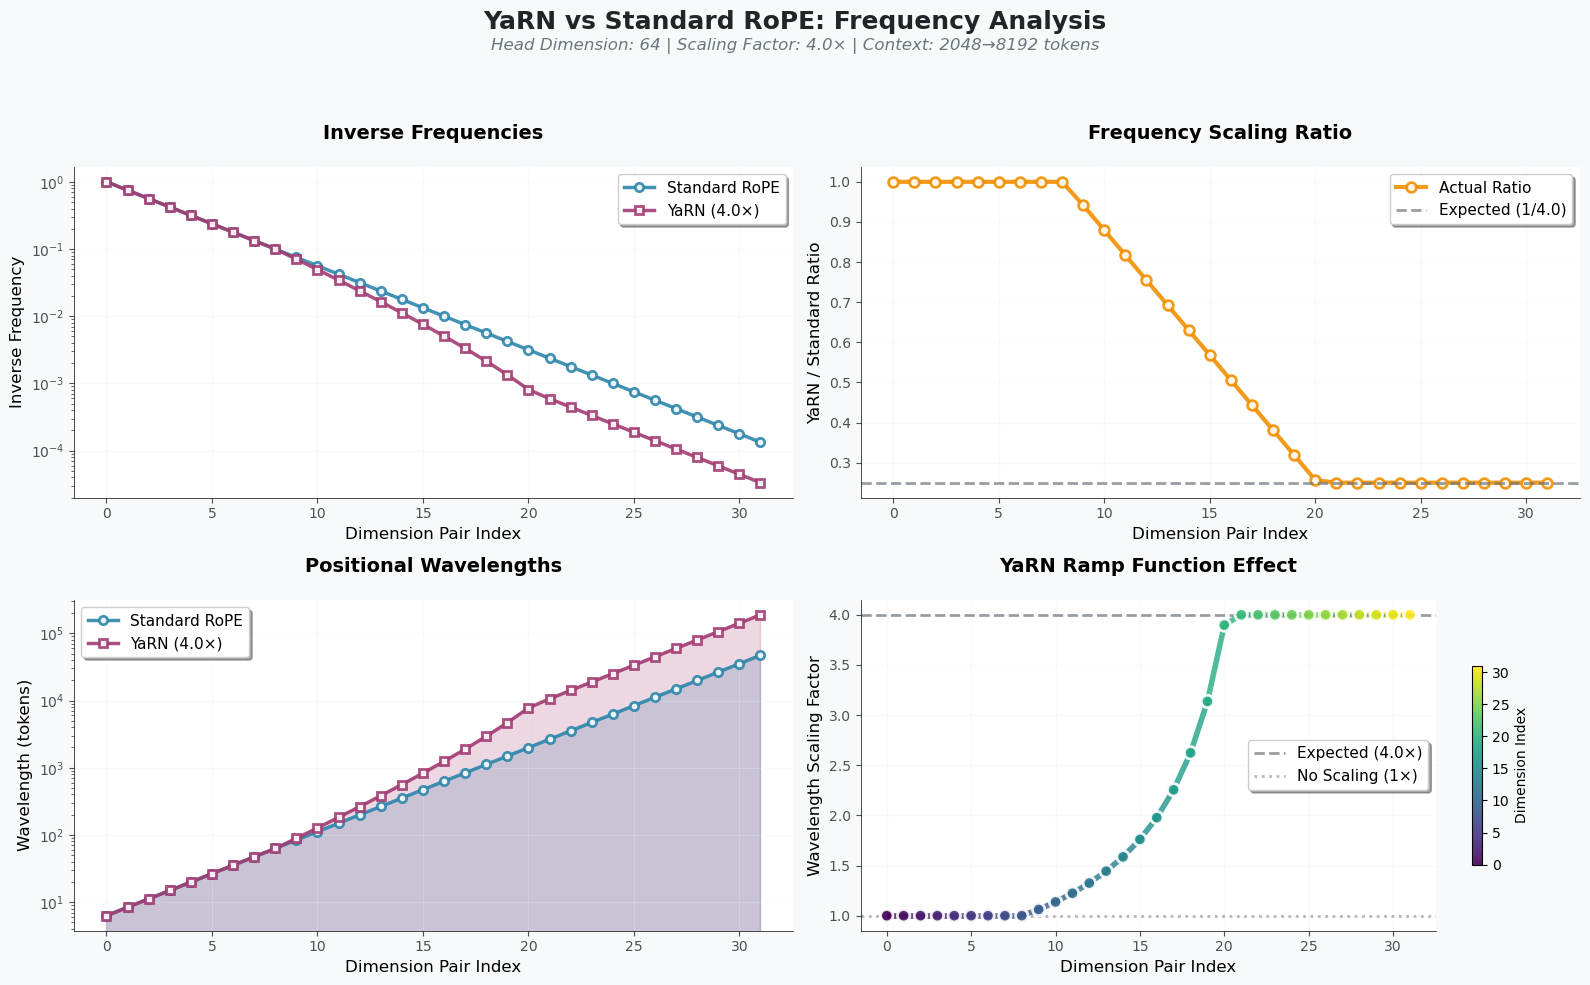

2025-09-14 21:46:21.448 | SUCCESS  | rope_visualization:visualize_frequency_scaling:400 - ✓ Beautiful frequency scaling visualization saved as './plots/yarn_frequency_analysis_scale_4.0x.png'

2025-09-14 21:46:21.449 | INFO     | rope_visualization:visualize_frequency_scaling:149 - === Visualizing YaRN Frequency Scaling (Factor: 16.0x) ===


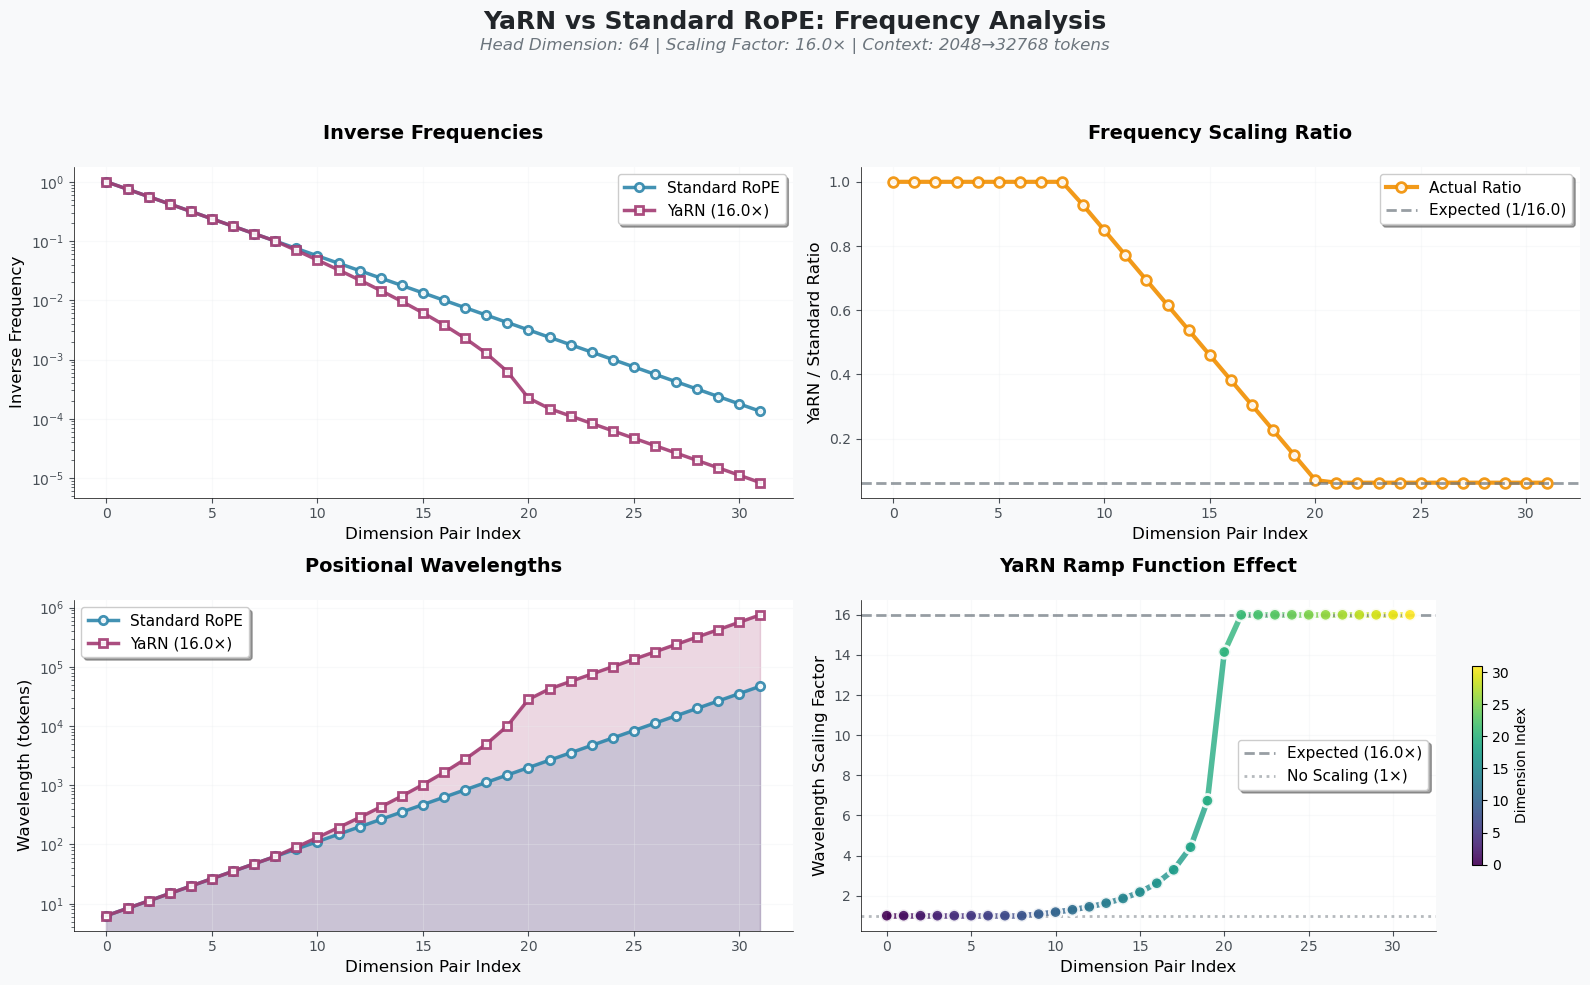

2025-09-14 21:46:22.529 | SUCCESS  | rope_visualization:visualize_frequency_scaling:400 - ✓ Beautiful frequency scaling visualization saved as './plots/yarn_frequency_analysis_scale_16.0x.png'

2025-09-14 21:46:22.529 | INFO     | rope_visualization:visualize_frequency_scaling:149 - === Visualizing YaRN Frequency Scaling (Factor: 2.0x) ===


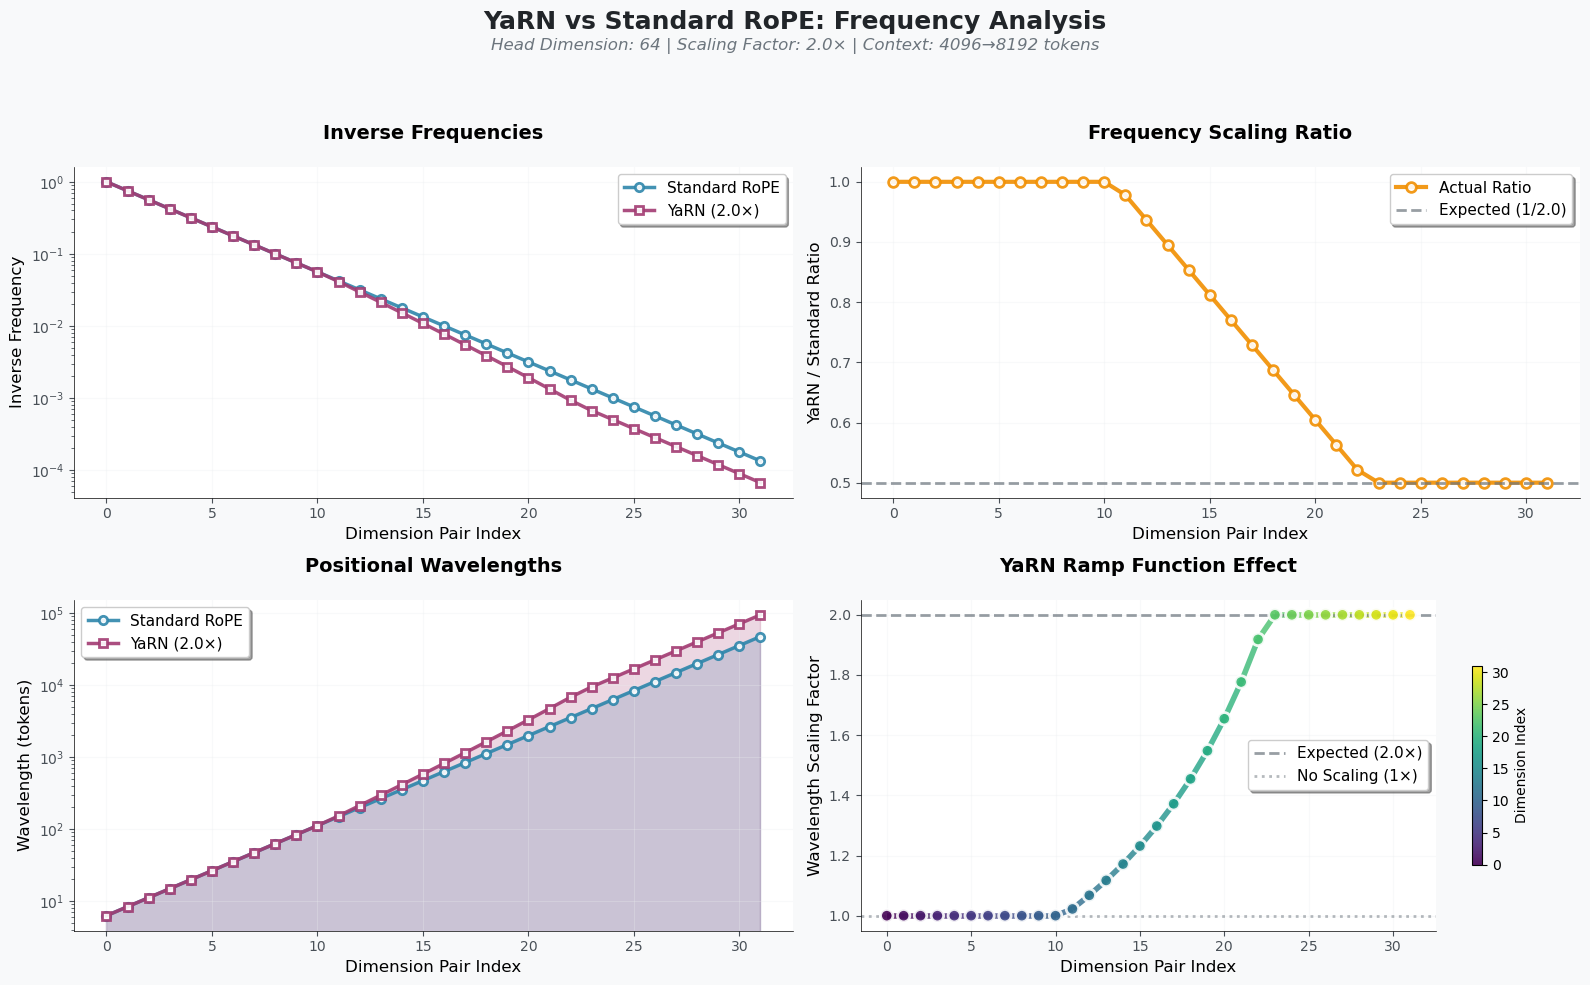

2025-09-14 21:46:23.507 | SUCCESS  | rope_visualization:visualize_frequency_scaling:400 - ✓ Beautiful frequency scaling visualization saved as './plots/yarn_frequency_analysis_scale_2.0x.png'

2025-09-14 21:46:23.508 | INFO     | rope_visualization:visualize_frequency_scaling:149 - === Visualizing YaRN Frequency Scaling (Factor: 1.5x) ===


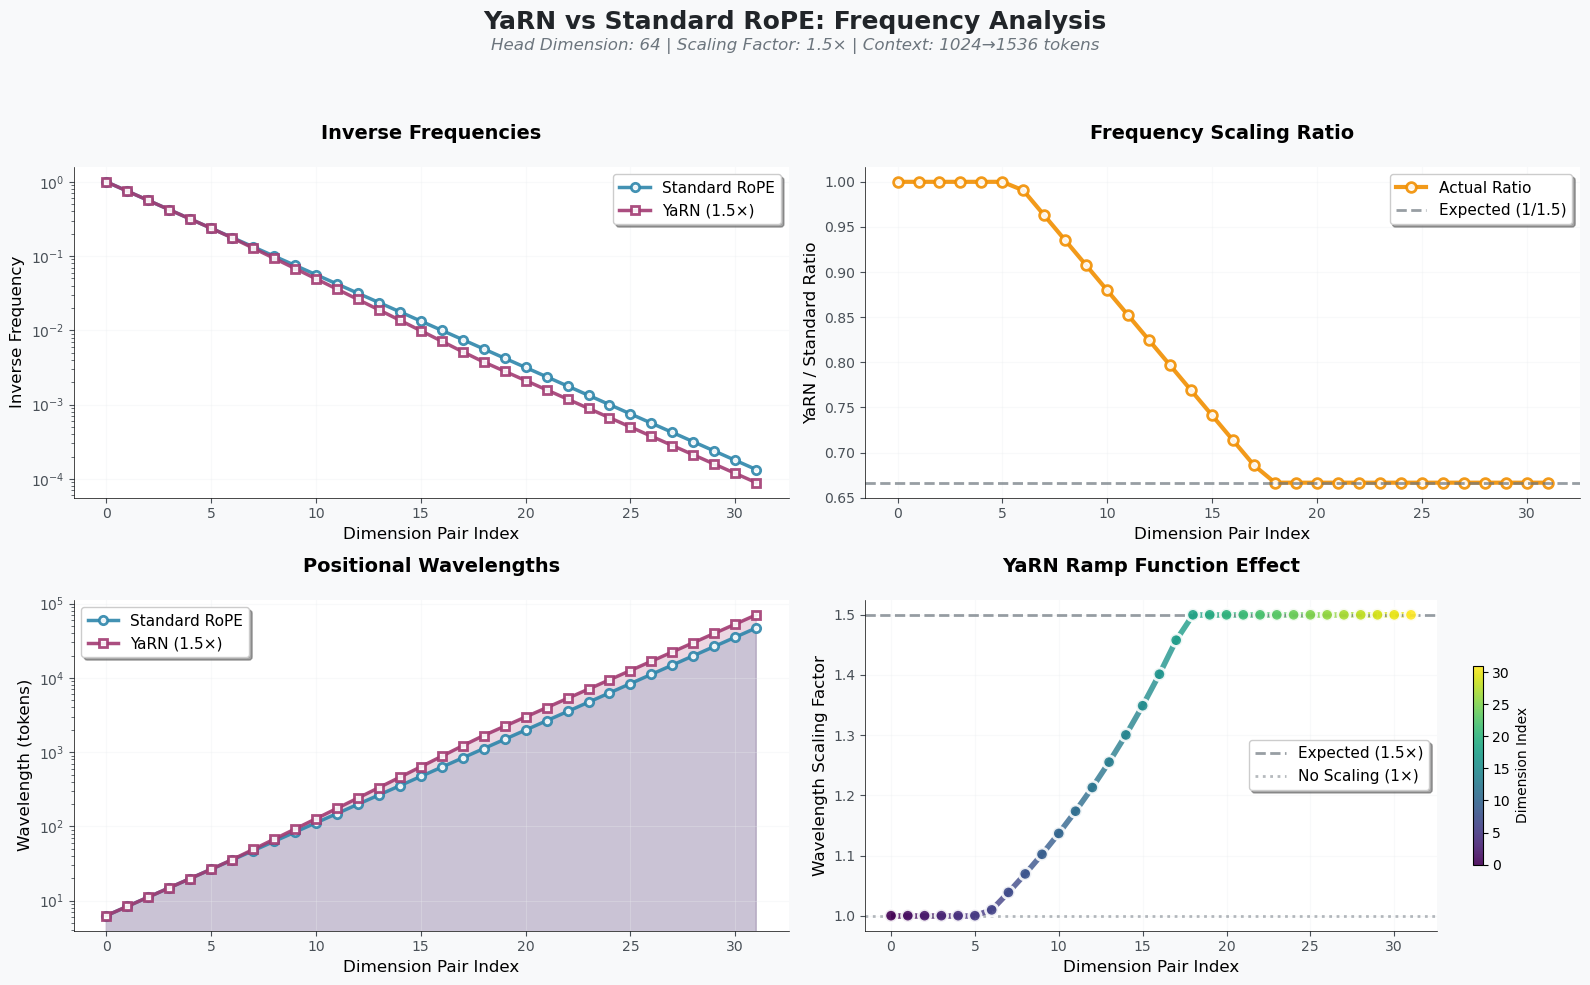

2025-09-14 21:46:24.575 | SUCCESS  | rope_visualization:visualize_frequency_scaling:400 - ✓ Beautiful frequency scaling visualization saved as './plots/yarn_frequency_analysis_scale_1.5x.png'

2025-09-14 21:46:24.575 | INFO     | rope_visualization:visualize_embeddings_heatmap:464 - === Visualizing RoPE Embeddings Heatmaps ===
2025-09-14 21:46:24.575 | INFO     | rope_visualization:visualize_embeddings_heatmap:465 - Scaling factors: [1.0, 2.0, 4.0, 8.0]
2025-09-14 21:46:24.575 | INFO     | rope_visualization:visualize_embeddings_heatmap:466 - Sequence lengths: [512, 1024, 2048, 4096]


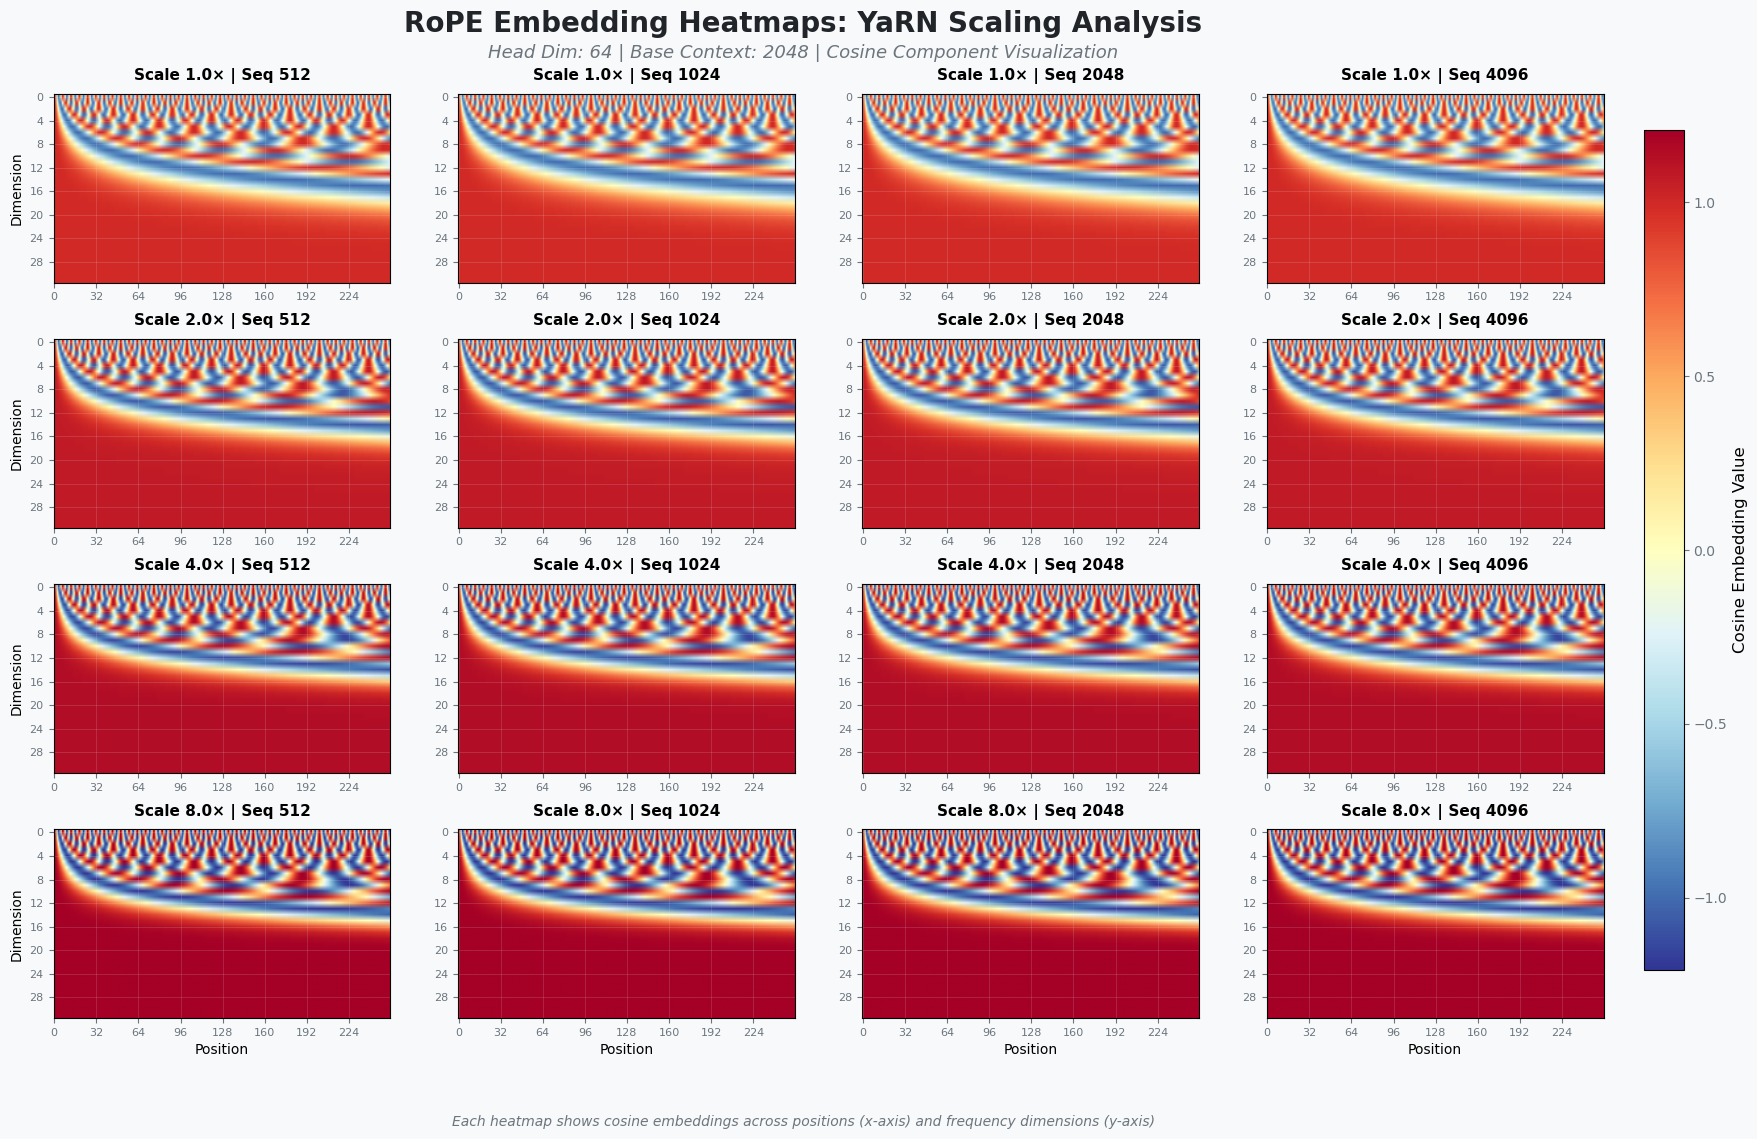

2025-09-14 21:46:26.621 | SUCCESS  | rope_visualization:visualize_embeddings_heatmap:641 - ✓ Beautiful embeddings heatmap visualization saved as './plots/rope_embeddings_heatmap_scales_4_lengths_4.png'
/home/ksharma/dev/git/gpt-oss-scratch/rope_visualization.py:739: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 0.88))


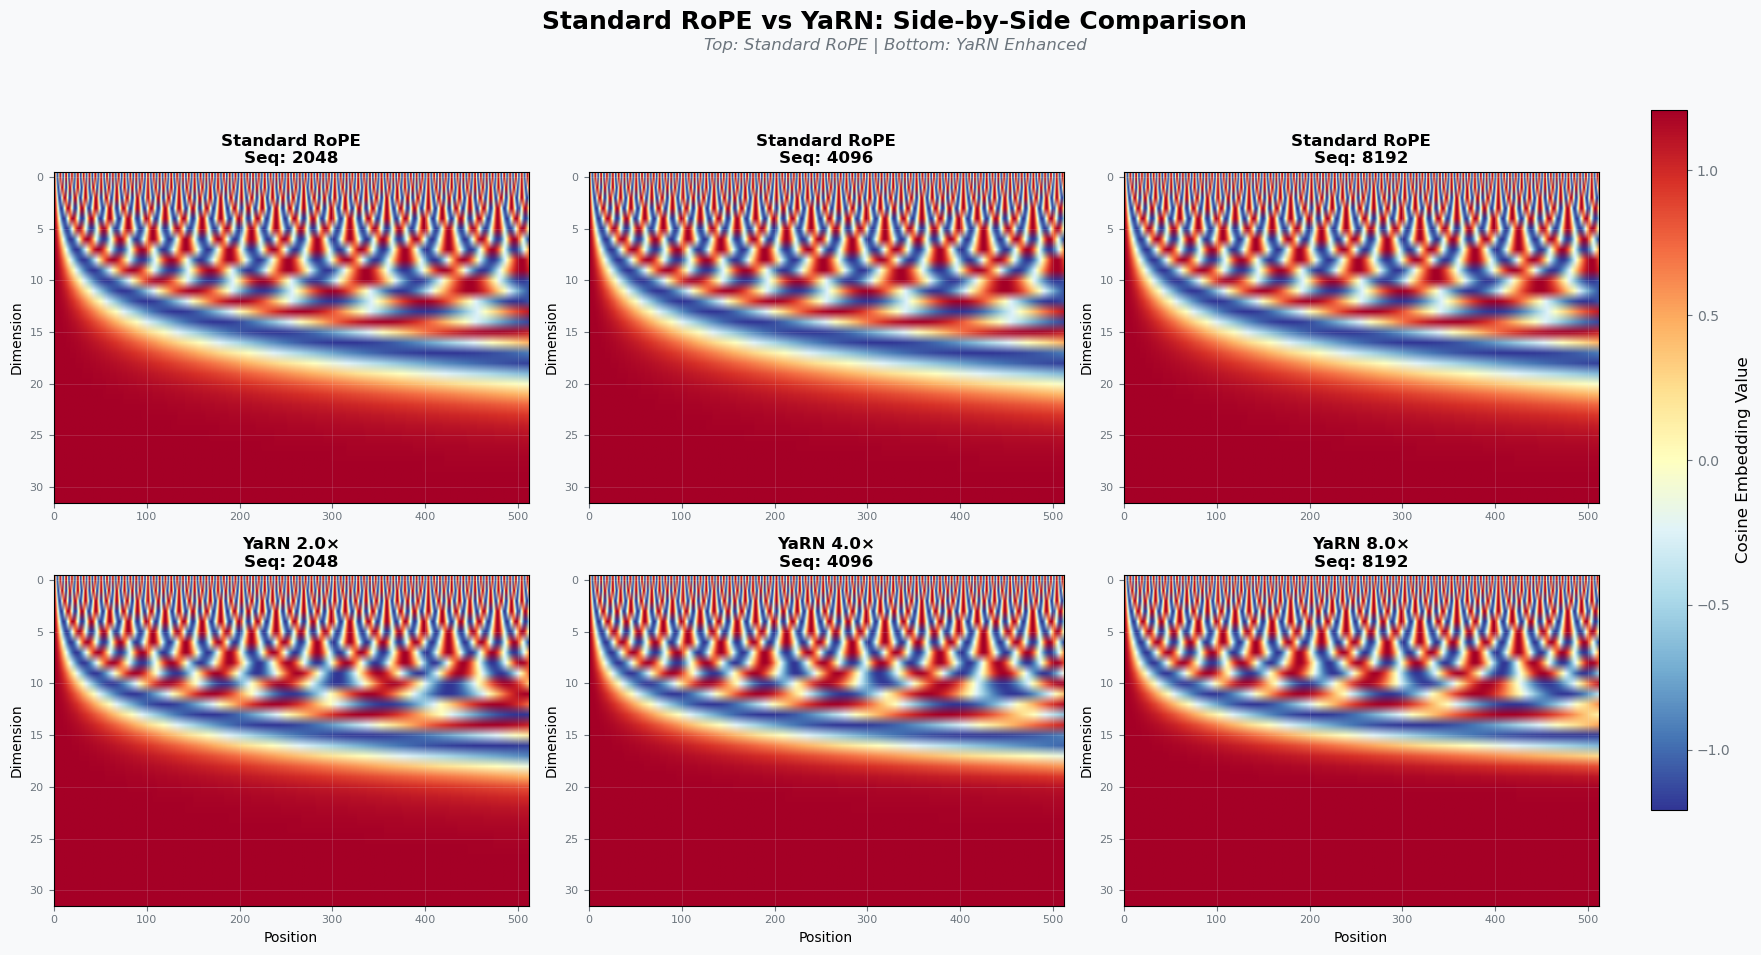

2025-09-14 21:46:28.700 | SUCCESS  | rope_visualization:_visualize_embedding_differences:753 - ✓ Comparison heatmap saved as './plots/rope_yarn_comparison_heatmaps.png'

2025-09-14 21:46:28.700 | INFO     | rope_visualization:benchmark_performance:405 - === Performance Benchmark ===
2025-09-14 21:46:28.712 | INFO     | rope_visualization:benchmark_performance:445 - Config {'seq_len': 512, 'batch_size': 8, 'num_heads': 8, 'head_dim': 64}: 0.10ms per forward pass
2025-09-14 21:46:28.700 | INFO     | rope_visualization:benchmark_performance:405 - === Performance Benchmark ===
2025-09-14 21:46:28.712 | INFO     | rope_visualization:benchmark_performance:445 - Config {'seq_len': 512, 'batch_size': 8, 'num_heads': 8, 'head_dim': 64}: 0.10ms per forward pass
2025-09-14 21:46:28.745 | INFO     | rope_visualization:benchmark_performance:445 - Config {'seq_len': 2048, 'batch_size': 4, 'num_heads': 12, 'head_dim': 64}: 0.29ms per forward pass
2025-09-14 21:46:28.797 | INFO     | rope_visualizatio

In [6]:
def run_all_tests():
    """Run all tests"""
    logger.info("Starting RotaryEmbedding Tests...\n")

    # Basic tests
    test_basic_functionality()
    test_yarn_scaling()

    # Advanced tests
    attn_no_rope, attn_with_rope = test_attention_patterns()
    test_relative_position_property()

    # Default 4x scaling with 2K context
    visualize_frequency_scaling()

    # Test extreme 16x scaling
    visualize_frequency_scaling(16.0)

    # Test with different base context length
    visualize_frequency_scaling(2.0, 4096)

    # Test small scaling factor
    visualize_frequency_scaling(1.5, 1024)

    visualize_embeddings_heatmap()

    # Performance
    benchmark_performance()

    logger.success("✅ All tests completed successfully!")


if __name__ == "__main__":
    run_all_tests()